## Image Classification on Caltech 101 Dataset


In [1]:
# For downloading dataset
from urllib.request import urlretrieve
import os

# For extracting dataset
import tarfile

# For reading images
import cv2

# Essentials :)
import numpy as np

# pretty printing python objects
import pprint

# for sorting dictionary by value
import operator

# for showing images inline
from matplotlib.pyplot import imshow 
%matplotlib inline 

# for making labels one-hot encoded
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# for splitting data into training and validation data
from sklearn.model_selection import train_test_split

# for CNN and NN models
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, Activation, Dense, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# For transfer learning
from keras.applications.inception_v3 import InceptionV3

# to save models
import json


# for printing size each variable is using
import sys

In [2]:
current_directory = os.path.dirname(os.path.realpath('__file__'))
current_directory

'C:\\Users\\bassa'

In [ ]:
tar = tarfile.open("C:\\Users\\bassa\\Downloads\\caltech-101\\caltech-101\\101_ObjectCategories.tar.gz", "r")
tar.extractall(path="C:\\Users\\bassa\\Downloads\\caltech-101\\caltech-101")
tar.close()

In [3]:
def get_images(object_category, data_directory):
    if (not os.path.exists(data_directory)):
        print("Data directory not found. Are you sure you downloaded and extracted dataset properly?")
        return
    obj_category_dir = os.path.join(os.path.join(data_directory,"101_ObjectCategories"),object_category)
    images = [os.path.join(obj_category_dir,img) for img in os.listdir(obj_category_dir)]
    return images

def read_image(image_path):
    """Read and resize individual images - Caltech 101 avg size of image is 300x200, so we resize accordingly"""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (300,200), interpolation=cv2.INTER_CUBIC)
    return img

In [4]:
def return_images_per_category(data_directory):
    categories = os.listdir(data_directory+"/101_ObjectCategories/")
    object_images_count_dict = {}
    for category in categories:
        object_images_count_dict[category] = len(os.listdir(data_directory+"/101_ObjectCategories/"+category))
    object_images_count_dict = sorted(object_images_count_dict.items(), key=operator.itemgetter(1), reverse=True)
    return object_images_count_dict

In [5]:
return_images_per_category("C:\\Users\\bassa\\Downloads\\caltech-101\\calt")

[('airplanes', 800),
 ('bonsai', 128),
 ('brain', 98),
 ('accordion', 55),
 ('bass', 54),
 ('barrel', 47),
 ('beaver', 46),
 ('brontosaurus', 43),
 ('anchor', 42),
 ('ant', 42),
 ('binocular', 33)]

In [6]:
len(return_images_per_category("C:\\Users\\bassa\\Downloads\\caltech-101\\calt"))

11

The number of objects we need to classify is 101. So, we can actually ignore the BACKGROUND_Google directory

The ROWS and COLS need to be fixed, however we have varied sized images. This is why the read_image method above resizes each image to 300x200 which is the average size of images (so most images wouldn't be affected).

What's the total number of images we need in our dataset?

In [7]:
total_count = 0
for category,count in return_images_per_category("C:\\Users\\bassa\\Downloads\\caltech-101\\calt"):
    if category == 'BACKGROUND_Google':
        continue;
    total_count += count
print("Total number of images in training data : ",total_count)

Total number of images in training data :  1388


In [8]:
def create_training_data(data_directory):
    i = 0
    X = np.ndarray((1388, 200, 300, 3), dtype=np.uint8)
    Y = []
    print("Preparing X and Y for dataset...")
    for category,_ in return_images_per_category(data_directory):
        if category == 'BACKGROUND_Google':
            continue
        print("Processing images of ",category)
        for image in get_images(category, data_directory):
            if not image.endswith('.jpg'):
                # to escape hidden ipynb checkpoints and other unnecessary files 
                continue
            X[i] = read_image(image)
            Y.insert(i,category) 
            i += 1
        print("Images processed : ",i+1," of 8678")
    print("Datasets constructed")
    return X,Y

In [9]:
X, Y = create_training_data("C:\\Users\\bassa\\Downloads\\caltech-101\\calt")

Preparing X and Y for dataset...
Processing images of  airplanes
Images processed :  801  of 8678
Processing images of  bonsai
Images processed :  929  of 8678
Processing images of  brain
Images processed :  1027  of 8678
Processing images of  accordion
Images processed :  1082  of 8678
Processing images of  bass
Images processed :  1136  of 8678
Processing images of  barrel
Images processed :  1183  of 8678
Processing images of  beaver
Images processed :  1229  of 8678
Processing images of  brontosaurus
Images processed :  1272  of 8678
Processing images of  anchor
Images processed :  1314  of 8678
Processing images of  ant
Images processed :  1356  of 8678
Processing images of  binocular
Images processed :  1389  of 8678
Datasets constructed


In [10]:
X.shape

(1388, 200, 300, 3)

Let's check a random example and see if its class matches or not

In [11]:
Y[676]

'airplanes'

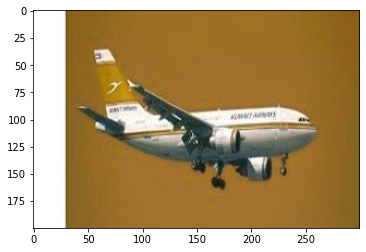

In [12]:
imshow(X[676])

Making one-hot encoded labels

In [13]:
label_encoder = LabelEncoder()
Y_integer_encoded = label_encoder.fit_transform(Y)
Y_integer_encoded

array([1, 1, 1, ..., 7, 7, 7], dtype=int64)

In [14]:
np.save('label_encoder.npy', label_encoder.classes_)

In [15]:
len(Y_integer_encoded)

1388

In [16]:
len(Y)

1388

In [17]:
len(X)

1388

Integers have ordering property which we don't want our ML models to learn since an apple isn't in any way greater than an airplane. So, we must create a one-hot encoding.

In [18]:
Y_one_hot = to_categorical(Y_integer_encoded)
Y_one_hot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
Y_one_hot[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [20]:
Y_one_hot.shape

(1388, 11)

In [21]:
len(Y_one_hot[0])

11

Basic Normalization

In [22]:
X_normalized = X.astype(np.float64) / 255

In [23]:
X[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [24]:
X_normalized[0]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [25]:
del X

Splitting the Data

In [26]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_normalized, Y_one_hot, test_size=0.25, random_state=42)

In [27]:
X_train.shape

(1041, 200, 300, 3)

In [28]:
Y_train.shape

(1041, 11)

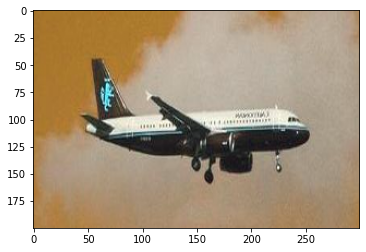

In [29]:
imshow(X_train[601])

model_rnn = keras.Sequential()
model_rnn.add(layers.Embedding(input_dim=(200,300),output_dim=64))
model_rnn.add(layers.LSTM(128))
model_rnn.add(layers.Dense(5))
model_rnn.summary

## Approach 1 - A Small CNN

In [30]:
model_cnn = Sequential()
model_cnn.add(Conv2D(16, (3,3), activation='relu', input_shape=(200,300,3)))
model_cnn.add(Conv2D(32, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(Conv2D(128, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(11, activation='softmax'))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 298, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 296, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 148, 32)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 146, 64)       18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 144, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 47, 72, 128)      0         
 2D)                                                    

In [31]:
model_cnn.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [32]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
history1 = model_cnn.fit(X_train, Y_train, batch_size=64, epochs=30, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Epoch 1/30
17/17 [==============================] - 69s 4s/step - loss: 2.6344 - accuracy: 0.5159 - val_loss: 1.3058 - val_accuracy: 0.6455
Epoch 2/30
17/17 [==============================] - 67s 4s/step - loss: 0.8878 - accuracy: 0.7368 - val_loss: 1.1149 - val_accuracy: 0.7147
Epoch 3/30
17/17 [==============================] - 67s 4s/step - loss: 0.4518 - accuracy: 0.8626 - val_loss: 1.0140 - val_accuracy: 0.7205
Epoch 4/30
17/17 [==============================] - 67s 4s/step - loss: 0.1808 - accuracy: 0.9433 - val_loss: 1.3772 - val_accuracy: 0.7522
Epoch 5/30
17/17 [==============================] - 66s 4s/step - loss: 0.0762 - accuracy: 0.9721 - val_loss: 1.6034 - val_accuracy: 0.7205
Epoch 6/30
17/17 [==============================] - 67s 4s/step - loss: 0.0335 - accuracy: 0.9914 - val_loss: 1.4829 - val_accuracy: 0.7464
Epoch 7/30
17/17 [==============================] - 66s 4s/step - loss: 0.0175 - accuracy: 0.9981 - val_loss: 1.9437 - val_accuracy: 0.7233
Epoch 7: early stopp

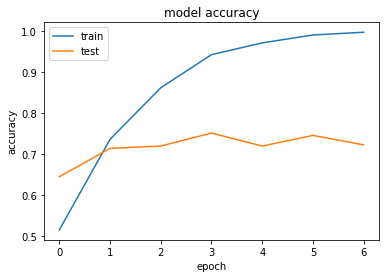

In [39]:
import matplotlib.pyplot as plt

plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Approach 2 - CNN Model with Dropout

In [43]:
# Architecture
model_cnn_dropout = Sequential()
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu', input_shape=(200,300,3)))
model_cnn_dropout.add(Conv2D(32, (3,3), activation='relu'))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_cnn_dropout.add(Conv2D(64, (3,3), activation='relu'))
model_cnn_dropout.add(MaxPooling2D(pool_size=2, strides=2))
model_cnn_dropout.add(Flatten())
model_cnn_dropout.add(Dense(512, activation='relu'))
model_cnn_dropout.add(Dropout(0.5))
model_cnn_dropout.add(Dense(11, activation='softmax'))
model_cnn_dropout.summary()

# loss and optimizer
model_cnn_dropout.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['accuracy'])

# training
callbacks = [ModelCheckpoint('cnn_model_dropout_two.h5', monitor='val_acc', save_best_only=True),
            EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
histor3 = model_cnn_dropout.fit(X_train, Y_train, batch_size=16, epochs=10, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 198, 298, 32)      896       
                                                                 
 conv2d_107 (Conv2D)         (None, 196, 296, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 98, 148, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_108 (Conv2D)         (None, 96, 146, 64)       18496     
                                                                 
 conv2d_109 (Conv2D)         (None, 94, 144, 64)       36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 47, 72, 64)       0         
 g2D)                                                 

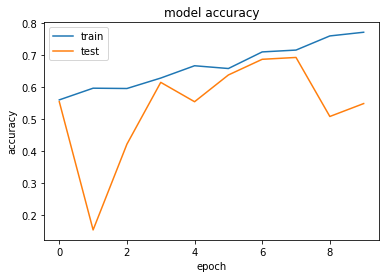

In [44]:
plt.plot(histor3.history['accuracy'])
plt.plot(histor3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Approach 3 - Transfer Learning

In [33]:
base_model = InceptionV3(weights='imagenet', include_top=False)

transfer_learning_arch = base_model.output
transfer_learning_arch = GlobalAveragePooling2D()(transfer_learning_arch)
transfer_learning_arch = Dense(1024, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
transfer_learning_arch = Dense(512, activation='relu')(transfer_learning_arch)
transfer_learning_arch = Dropout(0.4)(transfer_learning_arch)
predictions = Dense(11, activation='softmax')(transfer_learning_arch)

transfer_learning_model = Model(inputs=base_model.input, outputs=predictions)
transfer_learning_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_4 (Conv2D)              (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d_4[0][0]']               
 alization)                     32)                                                           

In [34]:
#We freeze the model excepted the added layers
#279 is number of mixed 9 layer
#248 is number of mixed 8 layer

for layer in transfer_learning_model.layers[:280]:
    layer.trainable = False
for layer in transfer_learning_model.layers[280:]:
    layer.trainable = True

In [35]:
opt=Adadelta(lr=1.0, rho=0.9, epsilon=1e-08, decay=0.0)
transfer_learning_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

C:\Users\bassa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adadelta.py:79: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [36]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')]
history2 = transfer_learning_model.fit(X_train, Y_train, batch_size=32, epochs=15, verbose=1, validation_data=(X_validation,Y_validation), callbacks=callbacks)

Epoch 1/15
33/33 [==============================] - 38s 1s/step - loss: 0.5777 - accuracy: 0.8415 - val_loss: 0.1824 - val_accuracy: 0.9539
Epoch 2/15
33/33 [==============================] - 35s 1s/step - loss: 0.0607 - accuracy: 0.9885 - val_loss: 0.1435 - val_accuracy: 0.9654
Epoch 3/15
33/33 [==============================] - 36s 1s/step - loss: 0.0177 - accuracy: 0.9971 - val_loss: 0.0916 - val_accuracy: 0.9769
Epoch 4/15
33/33 [==============================] - 36s 1s/step - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0873 - val_accuracy: 0.9741
Epoch 5/15
33/33 [==============================] - 35s 1s/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0660 - val_accuracy: 0.9798
Epoch 6/15
33/33 [==============================] - 36s 1s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0816 - val_accuracy: 0.9741
Epoch 7/15
33/33 [==============================] - 36s 1s/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.0726 - val_accuracy: 0.9798
Epoch 8/15
33/33 [==

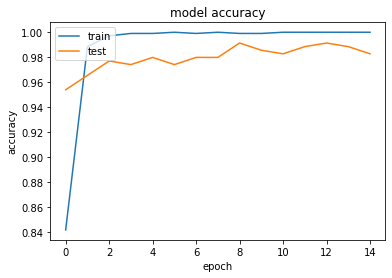

In [40]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#                                             Thank You